In [ ]:
import re
from os import path
from time import time

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    cross_val_score,
    RandomizedSearchCV,
)

In [ ]:
pandarallel.initialize(progress_bar=True)

# Carregar os dados

## Tweets

In [ ]:
# Definir caminho do arquivo
filename = "labeled_data.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Carregar dados
data = pd.read_parquet(filepath)

# Amostra dos dados
data.sample(10)

## Limpeza de Dados

No modelo Soma das Frequencias*, precisamos saber a quantidade de determinadas palavras que aparecem em tweets positivos, negativos e neutros.

Removeremos as Stopwords (palavras que não adicionam muito significado ao texto).

Para melhorar o modelo, utilizaremos o Stemming, que visa remove alguns [afixos](https://pt.wikipedia.org/wiki/Afixo) das palavras. Exemplo: papel gramatical, tempo, morfologia derivacional, deixando apenas o radical da palavra.
Assim, contaremos apenas os radicais das palavras em vez de suas derivações.

Referências:

- [StopWords](https://en.wikipedia.org/wiki/Stop_word)
- [Stemming](https://en.wikipedia.org/wiki/Stemming)

In [ ]:
def preprocess_data(string, stopwords, stemmer=None):

    # Remover os Emojis e Pontuações
    string_tratada = re.sub("\W", " ", string)

    # Remover stopwords
    string_tratada = " ".join(
        [
            substring
            for substring in string_tratada.split()
            if substring not in stopwords
        ]
    )

    # Stemming
    if stemmer:
        string_tratada = " ".join(
            [stemmer.stem(substring) for substring in string_tratada.split()]
        )

    # Remover espaços extras
    string_tratada = re.sub(" +", " ", string_tratada)
    string_tratada = re.sub("(^ )", "", string_tratada)
    string_tratada = re.sub("( $)", "", string_tratada)

    return string_tratada

In [ ]:
# Obter as stopwords
portuguese_stopwords = nltk.corpus.stopwords.words("portuguese")

# Inicializar o Stemmer
rlp_stemmer = nltk.stem.RSLPStemmer()

In [ ]:
# Mostra das stopwords
pd.Series(portuguese_stopwords).sample(5)

### Demonstração do Tratamento

In [ ]:
tweet = data["text"].sample(1).values[0]
tweet_limpo = preprocess_data(tweet, portuguese_stopwords)
tweet_limpo_stemmed = preprocess_data(tweet, portuguese_stopwords, rlp_stemmer)

print("Tweet Original: {}".format(tweet))
print("")
print("Tweet Limpo   : {}".format(tweet_limpo))
print("")
print("Tweet Stemed  : {}".format(tweet_limpo_stemmed))

## Aplicação da Limpeza

In [ ]:
data["cleaned"] = data["text"].parallel_apply(
    lambda x: preprocess_data(x, portuguese_stopwords, rlp_stemmer)
)

In [ ]:
data.sample(5)

# Engenharia de Atributos: Soma das Frequencias

Este modelo é extremamente simples.

Vamos transformar o texto numa representação vetorial utilizando o somatório da frequencia que cada palavra aparece nos tweets por rótulo.

## Gerar dicionário de frequencias

Basicamente criaremos três dicionários, um positivo, um negativo e um neutro.

Cada dicionário terá a soma das vezes que a palavra aparece em seu respectivo rótulo (positivo, negativo ou neutro) em todo o dataset.

### Separar conjuntos de treinamento e teste

Aqui faremos a separação de conjunto de treino e teste.

O dicionário será criado utilizando o conjunto de treino, e posteriormente verificado sua eficácia no conjunto de teste.

In [ ]:
X_train, X_test = train_test_split(data, random_state=42)

In [ ]:
# Aqui vamos criar nosso dicionário
def gerador_dicionario_tweet(tweet, dicionario):
    words = tweet.split()

    for word in words:
        dicionario[word] = dicionario.get(word, 0) + 1

In [ ]:
dicionario_positivo = {}

X_train[X_train["label"] == 1]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_positivo)
)

print("Chaves: {}".format(len(dicionario_positivo.keys())))

In [ ]:
dicionario_neutro = {}

X_train[X_train["label"] == 0]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_neutro)
)

print("Chaves: {}".format(len(dicionario_neutro.keys())))

In [ ]:
dicionario_negativo = {}

X_train[X_train["label"] == -1]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_negativo)
)

print("Chaves: {}".format(len(dicionario_negativo.keys())))

### Visualização dos Dicionários

In [ ]:
dicionarios = pd.DataFrame(
    [
        pd.Series(dicionario_positivo, name="positivo"),
        pd.Series(dicionario_neutro, name="neutro"),
        pd.Series(dicionario_negativo, name="negativo"),
    ]
).T

In [ ]:
dicionarios.sample(10)

## Gerar feature vector

Aqui nós transformaremos os textos em um vetor para podermos utilizá-los em um aprendizado supervisionado.

Nosso vetor será representado em três dimensões, uma para positivo, uma para negativo e outro para neutro.

O valor de cada dimensão é definido como o somatório das frequencias de cada palavra do tweet no dicionário da dimensão (positivo, negativo, neutro)

In [ ]:
def gerar_feature_vector(
    string, dicionario_positivo, dicionario_neutro, dicionario_negativo
):
    tokens = string.split()

    # Calcula o valor de cada dimensão do vetor
    feature_positiva = sum([dicionario_positivo.get(word, 0) for word in tokens])
    feature_neutra = sum([dicionario_neutro.get(word, 0) for word in tokens])
    feature_negativa = sum([dicionario_negativo.get(word, 0) for word in tokens])

    return pd.Series(
        [feature_positiva, feature_neutra, feature_negativa],
        index=["positiva", "neutra", "negativa"],
    )

### Demonstração da Geração do Feature Vector

In [ ]:
tweet = X_train["cleaned"].sample(1).values[0]
feature_vector = gerar_feature_vector(
    tweet, dicionario_positivo, dicionario_neutro, dicionario_negativo
)

print("Tweet: {}".format(tweet))
feature_vector

### Aplicar a Geração do Feature Vector em todo o Dataset de Treino

In [ ]:
# Gerar Features Train
features_train = X_train["cleaned"].parallel_apply(
    lambda x: gerar_feature_vector(
        x, dicionario_positivo, dicionario_neutro, dicionario_negativo
    )
)
features_train["label"] = X_train["label"]

In [ ]:
features_train.sample(5)

In [ ]:
X_features_train = features_train[["positiva", "neutra", "negativa"]]
X_features_train.sample(5)

In [ ]:
y_features_train = features_train["label"]
y_features_train.sample(5)

### Aplicar a Geração do Feature Vector em todo o Dataset de Teste

In [ ]:
# Gerar Features Teste
features_test = X_test["cleaned"].parallel_apply(
    lambda x: gerar_feature_vector(
        x, dicionario_positivo, dicionario_neutro, dicionario_negativo
    )
)
features_test["label"] = X_test["label"]

In [ ]:
features_test.sample(5)

In [ ]:
X_features_test = features_test[["positiva", "neutra", "negativa"]]
X_features_test.sample(5)

In [ ]:
y_features_test = features_test["label"]
y_features_test.sample(5)

## Feature Scaling

Aqui vamos normalizar os dados utilizando o Standard Scaler


Referências:
 - [https://en.wikipedia.org/wiki/Normalization_(statistics)](https://en.wikipedia.org/wiki/Normalization_(statistics))
 - [https://en.wikipedia.org/wiki/Standard_score](https://en.wikipedia.org/wiki/Standard_score)
 - [https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)

In [ ]:
# Inicializar o Scaler
scaler = StandardScaler()

# Treinar o Scaler
scaler.fit(X_features_train)

In [ ]:
# Transformar o conjunto de treinamento
transformed = scaler.transform(X_features_train)

# Gerar um dataframe com a saída do scaler
X_features_train_scaled = pd.DataFrame(transformed, columns=scaler.feature_names_in_)

# Amostra
X_features_train_scaled.sample(5)

In [ ]:
transformed = scaler.transform(X_features_test)

# Gerar um dataframe com a saída do scaler
X_features_test_scaled = pd.DataFrame(transformed, columns=scaler.feature_names_in_)

# Amostra
X_features_test_scaled.sample(5)

# Learning


## Baseline Score

Aqui vamos, criar um score de base. Ou seja, o resultado que conseguiriamos com o menor esforço possível (que é atribuir indiscriminadamente qualquer valor)

Referências:
- [https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

In [ ]:
# Assumindo tudo como 0
score_assumindo_tudo_neutro = f1_score(
    y_features_train, [0 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_neutro * 100))

In [ ]:
# Assumindo tudo como -1
score_assumindo_tudo_negativo = f1_score(
    y_features_train, [-1 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_negativo * 100))

In [ ]:
# Assumindo tudo como 1
score_assumindo_tudo_positivo = f1_score(
    y_features_train, [1 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_positivo * 100))

In [ ]:
# Baseline Score
baseline_score = np.max(
    [
        score_assumindo_tudo_neutro,
        score_assumindo_tudo_negativo,
        score_assumindo_tudo_positivo,
    ]
)

print("F-Score: {:.2f}%".format(baseline_score * 100))

## Logistic Regression

Referências:
- [https://en.wikipedia.org/wiki/Logistic_regression](https://en.wikipedia.org/wiki/Logistic_regression)
- [https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [ ]:
log = LogisticRegression(random_state=42)

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [ ]:
params = {
    "C": np.linspace(0.5, 2, 100),
    "tol": np.linspace(1e-5, 1e-3, 100),
}

clf = RandomizedSearchCV(log, params, scoring="f1_macro", n_jobs=-1, random_state=42)
clf.fit(X_features_train_scaled, y_features_train)

print("Best F-Score: {:.2f}%".format(clf.best_score_ * 100))

In [ ]:
clf.best_params_

In [ ]:
classifier = clf.best_estimator_

#### Comparação com Métrica base

In [ ]:
print("Score Baseline : {:.2f}%".format(baseline_score * 100))
print("Score Modelo   : {:.2f}%".format(clf.best_score_ * 100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score - clf.best_score_) * 100))

### Performance no Conjunto de Treino

In [ ]:
y_pred = classifier.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="macro")
print("F-Score: {:.2f}%".format(score * 100))

### Curva de Aprendizado

In [ ]:
def plot_learning_curve(estimator, X, y, scoring):

    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")

    plt.xlabel("Training examples")
    plt.ylabel("Score: {}".format(scoring))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.ylim(round(min([np.min(train_scores), np.min(test_scores)]), 2) - 0.01, 1.01)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )

    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")

    return plt

In [ ]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_macro"
)
plt.show()

## Histogram-Based Gradient Boosting

Referências:
- [https://en.wikipedia.org/wiki/Gradient_boosting](https://en.wikipedia.org/wiki/Gradient_boosting)
- [https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting)

In [ ]:
hgb = HistGradientBoostingClassifier(
    tol=0.00024,
    min_samples_leaf=5,
    learning_rate=0.74,
    random_state=42,
)

In [ ]:
s1 = time()
scores = cross_val_score(
    hgb, X_features_train_scaled, y_features_train, scoring="f1_macro"
)
hgb_score = scores.mean()

s2 = time()
print("Elapsed Time: ", int(s2 - s1), "seconds")

print("F-Score: {:.2f}%".format(hgb_score * 100))

In [ ]:
hgb.fit(X_features_train_scaled, y_features_train)

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [ ]:
# hgb = HistGradientBoostingClassifier(random_state = 42)
# params = {
#    "learning_rate": np.linspace(0.01, 1, 20),
#    "tol": np.linspace(1e-5, 1e-3, 100),
#    'min_samples_leaf': [x for x in range(1,11)],
# }
#
# clf = RandomizedSearchCV(hgb, params, scoring='f1_macro', random_state=42)
# clf.fit(X_features_train_scaled, y_features_train)
#
# print("Best F-Score: {:.2f}%".format(clf.best_score_*100))

In [ ]:
# clf.best_params_
print(
    {
        "tol": 0.00023999999999999998,
        "min_samples_leaf": 5,
        "learning_rate": 0.7394736842105263,
    }
)

In [ ]:
# rf = clf.best_estimator_

#### Comparação com Métrica base

In [ ]:
print("Score Baseline : {:.2f}%".format(baseline_score * 100))
print("Score Modelo   : {:.2f}%".format(hgb_score * 100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score - hgb_score) * 100))

### Performance no Conjunto de Treino

In [49]:
y_pred = hgb.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="macro")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 42.85%


### Curva de Aprendizado

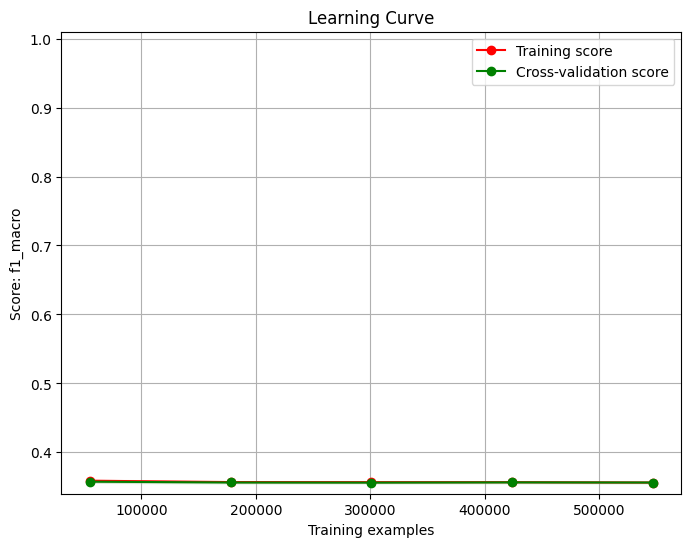

In [50]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_macro"
)
plt.show()

## Validação em conjunto de Teste

In [51]:
y_pred = hgb.predict(X_features_test_scaled)
score = f1_score(y_features_test, y_pred, average="macro")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 41.61%


### Preditos Positivos

In [52]:
preditos_positivos = X_test[y_pred == 1]

#### Falso Positivo -> Negativo

In [53]:
preditos_positivos[preditos_positivos["label"] == -1]["text"].sample(10).values

array(['literalmente 😭',
       'hoje infelizmente terei que voltar a vida de acadêmica 😩',
       'minha tela de início ficou tão linda 😭',
       'chegar + uma vez atrasada no clg 😴',
       'hoje foi um dia tão bom 😭😭😭',
       '💀 o nome do clube é literalmente sport lisboa e benfica, tu não és neto do bronx és neto de um burro',
       'meu deus a maria da luz 😭', 'que sonooo, bom dia 😭',
       'passa o tutorial😭',
       'se ele for o kas ou usado pelo vecna não vejo saída pra ele 😫'],
      dtype=object)

#### Falso Positivo -> Neutro

In [54]:
preditos_positivos[preditos_positivos["label"] == 0]["text"].sample(10).values

array(['pitty no faustão 😱 a paz mundial meu pai', 'nasceu 💥',
       'retwitta ai família o react do meno tody ja passa dos . views no youtube ☡🔥 (acessa o link abaixo pra conferir…',
       'eu apoio ✋',
       'agora é que disseste tudo 😂 estou a pensar até mudar o emoji para 🤡',
       'e aqui estou eu 🤦🏽\u200d♂️😂', 'casualsss😭🔥 karan x vivov pro',
       'kkk porra 😂',
       'kk sensação estranha eu mesma me demitir e me contratar 😂',
       'faltou energia no hospital, na verdade nos bairros quase tudin kkk 😂 também espero que esteja tudo bem com vose te amo'],
      dtype=object)

#### Verdadeiro Positivo

In [55]:
preditos_positivos[preditos_positivos["label"] == 1]["text"].sample(10).values

array(['queimado em pneu 👍',
       'você smp soube que eu já tinha alguém, não venha c chantagem me fazer refém 🎶',
       'bobo ma aq 😍',
       'e também não se preocupa sempre vamos está aqui pra fude que precisar, nos te amamos 💖',
       '[ / : ] : o jeito que você se arruma pra ver outro e me manda foto é diferente. ♥ [ / : ] 🧜🏽: kkk…',
       "a minha boca diz ' te amo' pra dentro, só eu posso ouvir 🎶",
       'o meu castelo tem um quarto só 🎶',
       'maravilhosas!!! pai mãe e melhor professora ♡',
       'quinta eu broto aí e levo os bglh pra nós pintar 😉',
       'contagem regressiva 😋'], dtype=object)

### Preditos Negativos

In [56]:
preditos_negativos = X_test[y_pred == -1]

#### Falso Negativo -> Positivo

In [57]:
preditos_negativos[preditos_negativos["label"] == 1]["text"].sample(10).values

array(['tem um menino do meu lado e ele tava soando o nariz, dai perguntei "ta gripado?" ele "eu tô e você?" 😂😂😂',
       'eu já assisti + de x pqp n dá 😍',
       'é pq eu tô doida pra ser titia do filho de vcs 😍',
       'assistir friends é tão 🥰🤍💖✨😅🥺', 'só saudades 😔❤️',
       'acordei chorando 👌',
       'só quero saber qual vai fazer a carteirinha de visita 😂😂',
       'ainda tô presa nesse sorriso. \U0001f979😍',
       'eu q li traficante 😃👍', 'mas eu sei 😎 é rápido po'], dtype=object)

#### Falso Negativo -> Neutro

In [58]:
preditos_negativos[preditos_negativos["label"] == 0]["text"].sample(10).values

array(['nem eu canso 🔥',
       'nao sei ainda😂 faz duas semanas que tô esperando o cashback (não sei se é normal essa demora) mas ganhei gb de bônus por pagar a fatura do celular por lá',
       'ih foi mal 🤦🏾😂', 'queria 😥',
       'não adianta falar mal depois ir lustrar os chifre 😂',
       'queria ter sono pra apagar a essas horas 😂',
       'so queria ta com meu pai hj, a distância é foda cara. 😢',
       'semana passada era lucca, agr sou eu... to só o pó, garganta inflamadissima e febre que nao passa 😰',
       'vontade de faltar.😰😰',
       'o set do rafael acabou comigo, e eu vou encher o saco dele até ele colocar no sound 😂'],
      dtype=object)

#### Verdadeiro Negativo

In [59]:
preditos_negativos[preditos_negativos["label"] == -1]["text"].sample(10).values

array(['eu quero😭😭', 'caralho hj eu n queria levantar da cama n 😓',
       'ela falou na live a era pra "n" não sei qm é "n"😭😭',
       'estou nem aguentando em pé 😣',
       'afs não podia ter pego sol, agora meu nariz tá sensível dnv 😒',
       'peloamor de merlin, não 😭',
       'dormi tarde , acordei cedo e ainda vou pra camila 😫',
       'quero outro ceruleitchon 😭 esse só me faz raiva 😭🤣🤣',
       'venham ter comigo pfv 💔', 'estou só piorando 😭'], dtype=object)

### Preditos Neutros

In [60]:
preditos_neutros = X_test[y_pred == 0]

#### Falso Neutro -> Positivo

In [61]:
preditos_neutros[preditos_neutros["label"] == 1]["text"].sample(10).values

array(['ultimamente tenho preguiça até de lavar meu cabelo. tô aqui com um artigo pra ler, um cabelo pra lavar e eu só queria dormir pra sempre 😌',
       '[ / : ] meu amor: amor muito obrigado ta [ / : ] meu amor: ganhei o remedio e te vi 😍',
       'eita 😏', 'olosho😂😂', 'te amo soninha ♥',
       'ameiii altura n sei sexualidade: hétero 😎 n entendi o "mto" kkk tb te gosto mto &lt;',
       'choque dele e de pilha, 😂😂😂👻👻👻🕳️🕳️🙈🙉🙊',
       'até a pesquisa do instituto bolsonarista poderdata mostra que lula será nosso próximo presidente 🥰❤️🥰❤️🥰❤️',
       'fiquei até agr falando com o pedro ❤',
       'tirar aquele sono que faltou da noite que nem dormi direito ✌'],
      dtype=object)

#### Falso Neutro -> Negativo

In [62]:
preditos_neutros[preditos_neutros["label"] == -1]["text"].sample(10).values

array(['ken hahshahshahshe😭😭', 'tá chegando, tô sentindo kkk😔',
       'aí entendo 😔',
       '“fui confundida como informante” 😭😭😭 devia tá devendo era a boca kkk fdp',
       'shshshs😭😭😭', 'mentiraaa 😭😭😭',
       'masquerade………🤦\u200d♀️🤦\u200d♀️🤦\u200d♀️😭',
       'parece que tô regredindo, não tô conseguindo me manter num foco e eu acho que tô me perdendo aos poucos…😕',
       'lauraaa tá na hora né kkk to triste 😣 @lauraol', 'apestosa 😭'],
      dtype=object)

#### Verdadeiro Neutro

In [63]:
preditos_neutros[preditos_neutros["label"] == 0]["text"].sample(10).values

array(['já suspeitava que iriam fazer isso, imagina quanta gente ainda acessa a página dele. twitch tá só progredindo 😅',
       'atenta 👀',
       'eu morro de rir com as coisas q samuel me conta kkk😅🤦🏽\u200d♀️',
       'ovias 😂', 'até parece que você nao aprendeu sábado né 👀 kkk',
       '😱 que assustador!',
       'alguém teria um pacote de macarrão e um molho de tomate pra eu fazer sopa pra mim e pra minha mãezinha por favor 😭? estou doente, tenho câncer em estado avançado, perdi parte da visão e audição 😔 moro com a minha mãe que já é idosa, peço doações por nós 🙏',
       'ate falaria relatable mas meu pai nunca perguntou se eu tava bem 😂',
       'bolsonaro usa deus. deus usa lula! 👊🇧🇷',
       "sigam a 💯 💯 let's go...!! só os melhores galera!!!…"],
      dtype=object)